In [289]:
# From https://medium.com/swlh/classifying-loans-based-on-the-risk-of-defaulting-using-logistic-regression-9bd9c6b44640
# From https://www.kaggle.com/jazeel66/loan-prediction

import numpy as np
import math
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [271]:
# From https://www.kaggle.com/ninzaami/loan-predication/data
# 'Loan Predication'
data = pd.read_csv('loan.csv')

In [272]:
data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [273]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [286]:
# drop ID
data.drop('Loan_ID', axis=1, inplace=True)

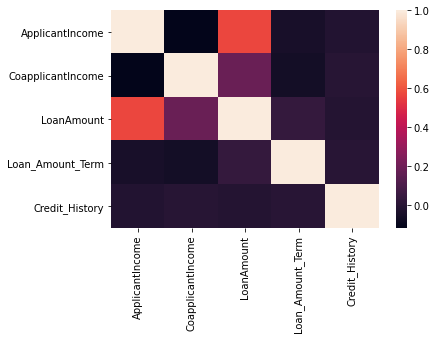

In [287]:
sns.heatmap(data.corr())

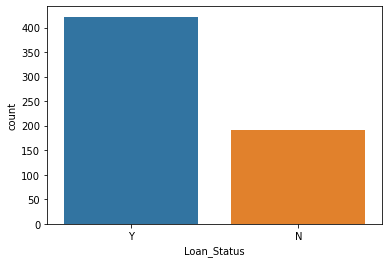

In [293]:
sns.countplot(x='Loan_Status', data=data)

In [288]:
object_columns = data.select_dtypes('object').columns.to_list()
object_columns.remove('Loan_Status')
object_columns

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Property_Area']

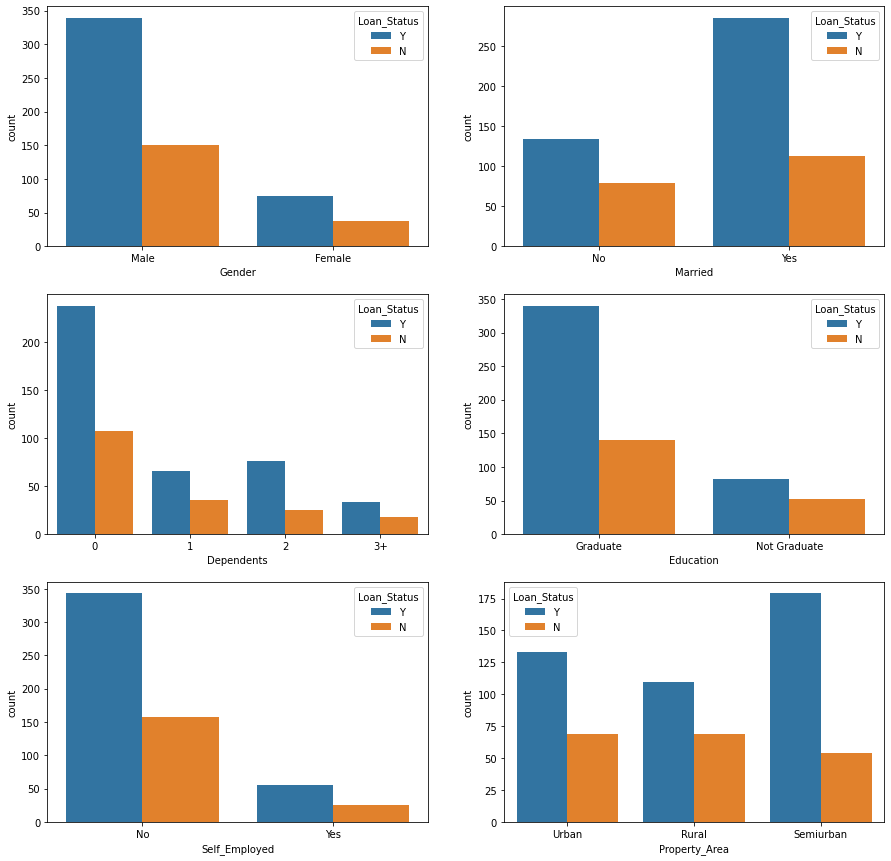

In [359]:
plt.figure(figsize=(15,15))

for index, column in enumerate(object_columns):
    plt.subplot(3, 2, index+1)
    sns.countplot(x=column, data=data, hue='Loan_Status')

In [328]:
for index, column in enumerate(data['Property_Area'].unique()):
    print(column)
    display(data[
        (data['Property_Area']==column)
    ]['Loan_Status'].value_counts(normalize=True).to_frame().style.format(
        formatter={'Loan_Status': '{:,.2%}'.format}
    ))

Urban


,Loan_Status
Y,65.84%
N,34.16%


Rural


,Loan_Status
Y,61.45%
N,38.55%


Semiurban


,Loan_Status
Y,76.82%
N,23.18%


In [354]:
numeric_columns = data.select_dtypes(['Int64', 'Float64']).columns.to_list()
# Loan_Amount_Term & Credit_History are too discrete to draw meaningful charts
numeric_columns.remove('Loan_Amount_Term')
numeric_columns.remove('Credit_History')
numeric_columns

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount']

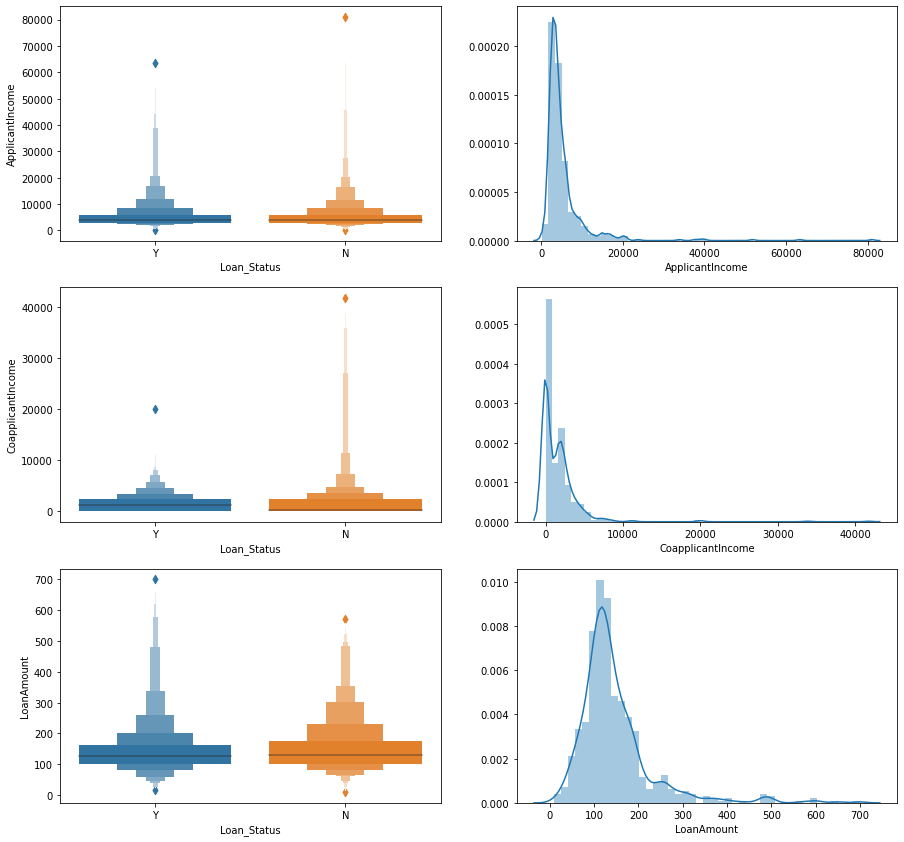

In [372]:
plt.figure(figsize=(15,25))
count = 1

for column in numeric_columns:    
    plt.subplot(5, 2, count)
    sns.boxenplot(x='Loan_Status', y= column, data=data)
    count +=1
    plt.subplot(5, 2, count)
    sns.distplot(data.loc[data[column].notna(), column])
    count+=1

In [360]:
data.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [362]:
# Replace the categorical values with the numeric equivalents that we have above
data_numeric = data
to_drop_features = ['Loan_Status']

# Iterate through the list of categorical features and one hot encode them.
for feature in object_columns:
    onehot = pd.get_dummies(data[feature], prefix=feature)
    data_numeric = data_numeric.drop(feature, axis=1)
    data_numeric = data_numeric.join(onehot)

data_numeric = data_numeric.dropna()
y = data_numeric['Loan_Status']
data_numeric = data_numeric.drop(to_drop_features, axis=1)

In [438]:
# Liblinear is a solver that is effective for relatively smaller datasets.
lr = LogisticRegression(solver='liblinear', class_weight='balanced')

In [439]:
# We will follow an 80-20 split pattern for our training and test data
X_train,X_test,y_train,y_test = train_test_split(
    pd.DataFrame(data_numeric), y, test_size=0.2, random_state = 0
)

In [440]:
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [441]:
# We will compare this vector of predictions to the actual target vector to determine the model performance.
y_pred = lr.predict(X_test)

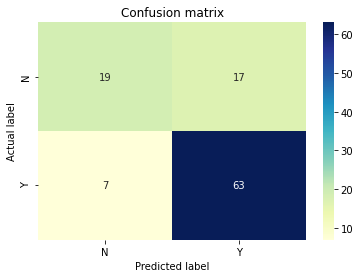

In [442]:
# Build the confusion matrix.
class_names=['N','Y']
confusion_matrix = metrics.confusion_matrix(y_test, y_pred, labels=class_names)

# The heatmap requires that we pass in a dataframe as the argument
ax = sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu", fmt="g")

ax.set(
    xlabel='Predicted label',
    ylabel='Actual label',
    xticklabels=class_names, 
    yticklabels=class_names,
    title='Confusion matrix'
)

plt.show()

In [443]:
# Print out our performance metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred, pos_label='Y'))
print("Recall:",metrics.recall_score(y_test, y_pred, pos_label='Y'))

Accuracy: 0.7735849056603774
Precision: 0.7875
Recall: 0.9


In [444]:
print("F1 Score:",metrics.f1_score(y_test, y_pred, pos_label='Y'))

F1 Score: 0.84


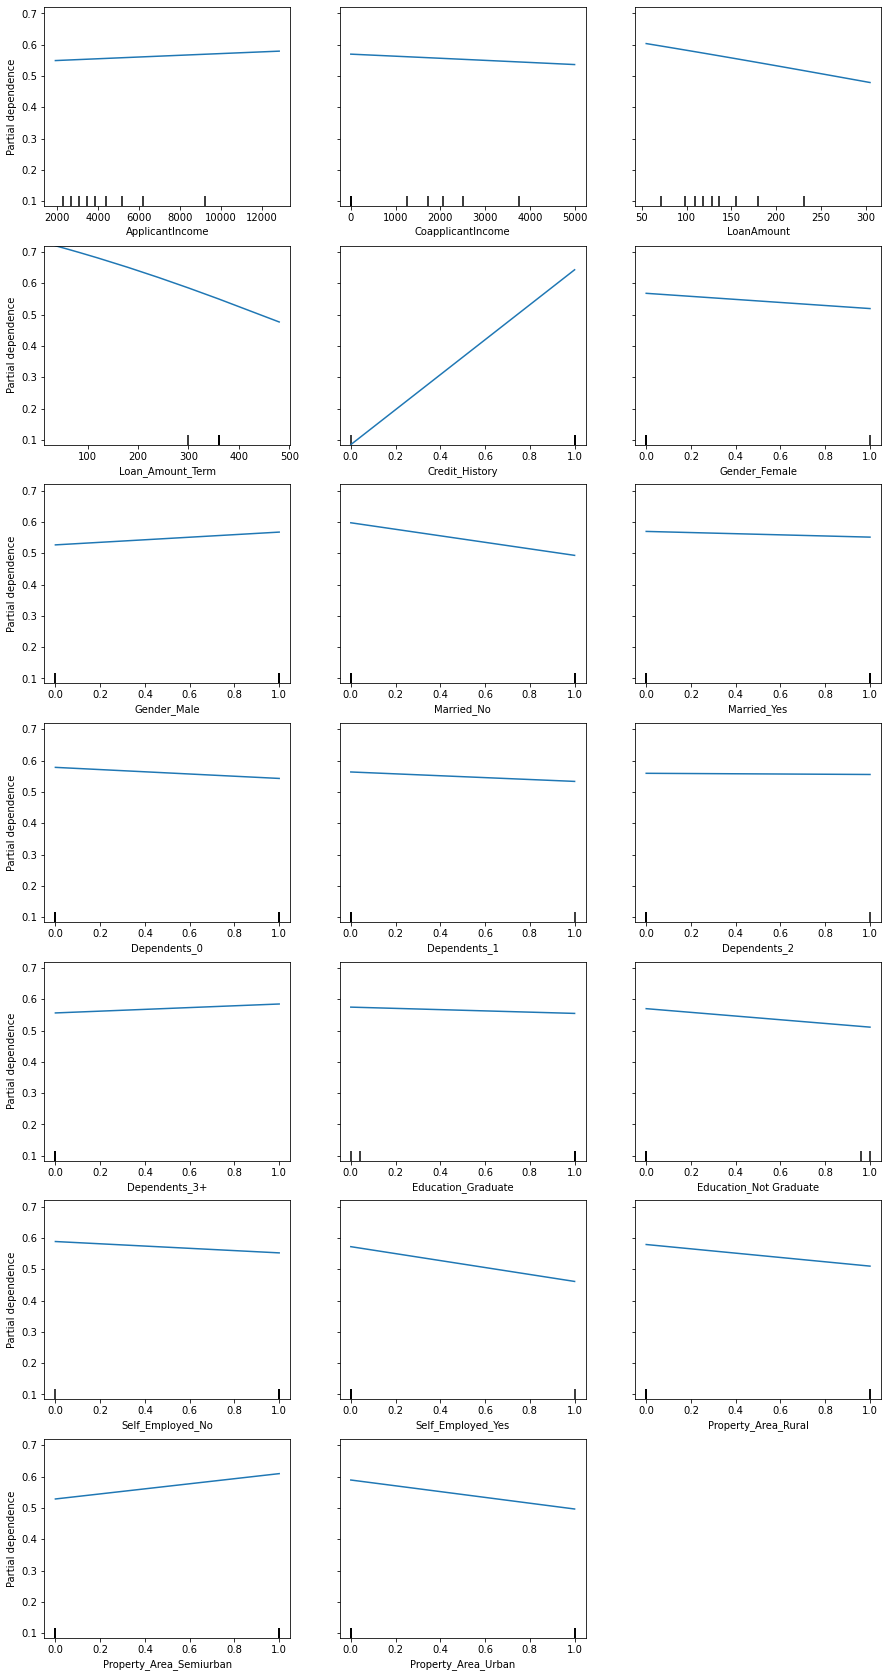

In [469]:
ffig, ax = plt.subplots(figsize=(15, 30))
plot_partial_dependence(lr, X_train, range(len(X_train.columns)), ax=ax)

In [470]:
lr.coef_

array([[ 1.44306297e-05, -3.44120471e-05, -2.56264906e-03,
        -3.06657309e-03,  3.16624415e+00, -2.49435478e-01,
         2.09509169e-01, -5.31596255e-01, -9.55970040e-02,
        -1.84195738e-01, -1.55704631e-01, -1.95090439e-02,
         1.50566603e-01, -1.05195375e-01, -3.03068737e-01,
        -1.91915051e-01, -5.61020461e-01, -3.53321494e-01,
         4.19753866e-01, -4.74696484e-01]])

In [471]:
coef_res = np.exp(lr.coef_)[0];
coef_res

array([ 1.00001443,  0.99996559,  0.99744063,  0.99693812, 23.71823463,
        0.77924056,  1.23307268,  0.58766616,  0.9088302 ,  0.83177298,
        0.85581193,  0.98068003,  1.16249273,  0.90014864,  0.73854833,
        0.82537698,  0.57062646,  0.70235136,  1.521587  ,  0.62207384])

In [472]:
coef_res = np.exp(lr.coef_)[0];
np.nonzero(coef_res>1)

(array([ 0,  4,  6, 12, 18]),)

In [481]:
lr.predict([X_test.iloc[4]])

array(['N'], dtype=object)

In [482]:
X_test.iloc[4]

ApplicantIncome            3180.0
CoapplicantIncome             0.0
LoanAmount                   71.0
Loan_Amount_Term            360.0
Credit_History                0.0
Gender_Female                 1.0
Gender_Male                   0.0
Married_No                    1.0
Married_Yes                   0.0
Dependents_0                  1.0
Dependents_1                  0.0
Dependents_2                  0.0
Dependents_3+                 0.0
Education_Graduate            1.0
Education_Not Graduate        0.0
Self_Employed_No              1.0
Self_Employed_Yes             0.0
Property_Area_Rural           0.0
Property_Area_Semiurban       0.0
Property_Area_Urban           1.0
Name: 396, dtype: float64